In [2]:
# The following file is being used to test the Pipeline
import matplotlib.pyplot as plt
''' Import statements for all the files involved'''
from main import *
from utils import *
from wfield_utils import *
from registration import *
from hemocorrection import *
from denoising import *
from debug_visualize import *
from data_loading_functions import *
from data_preprocessor import *
from tqdm import tqdm
import pickle
import scipy.io

In [3]:
# The folllowing code is from main(). 
# params are global variables used to modify the code
params = {
    'path_to_session_data':       r"C:\Users\evilm\Downloads\07-29-2024",
    'pipe_num':           0,              # select desired pipeline number
    'get_raw_brightness': False,
    'get_DeltaF':         False,
    'get_zScore':         False
          }
# This is inside def main()
# For purposes of testing to visualise the data we will do analysis here.
session_file_paths = get_file_paths(params['path_to_session_data'])
#print(session_file_paths)
# create an obj for each recording within the session
recording = rawDataPreprocessor(params['path_to_session_data'])

print(f'{datetime.datetime.now().time()}: Done loading session data into object')

# Currently 
# recording.all_frames.shape
blue_frames = recording.all_frames[:,0,...]
analog_data = load_dat_analog(recording.path_to_analog)
frame_times = load_mat_frameTimes(recording.path_to_frameTimes)
blue_ftimes = frame_times['frameTimes']

olfac_matfile = r"C:\Users\evilm\Downloads\07-29-2024\data_mixed_full_grating_OdorStimulus_202407291652168_mat.mat"
olfac_configs = pickle.loads(scipy.io.loadmat(olfac_matfile)['configs'].tostring())
olfac_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(olfac_matfile)['experiment_start_timestamp'].tostring())
#olfac_parameters = pickle.loads(scipy.io.loadmat(olfac_matfile)['parameters'].tostring())
# Skipping software environement
olfac_stim_frame_info = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info'].tostring())
#olfac_stim_frame_info_text = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info_text'].tostring())
olfac_user_data = pickle.loads(scipy.io.loadmat(olfac_matfile)['user_data'].tostring())
olfac_sync = scipy.io.loadmat(olfac_matfile)['sync']

16:15:01.684691: Done loading session data into object


C:\Users\evilm\AppData\Local\Temp\ipykernel_106908\3051858570.py:27: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_configs = pickle.loads(scipy.io.loadmat(olfac_matfile)['configs'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_106908\3051858570.py:28: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(olfac_matfile)['experiment_start_timestamp'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_106908\3051858570.py:31: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_stim_frame_info = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_106908\3051858570.py:33: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_user_data = pickle.loads(scipy.io.loadmat(olfac_matfile)['user_data'].tostring())


In [4]:

# Olfac Times
olfac_odortimes = np.array([time['time'] for time in list(olfac_stim_frame_info) ])
np.unique(olfac_odortimes[::2]-olfac_odortimes[1::2])

array([-6.01725245, -6.01708055, -6.01683092, -6.01664019, -6.01618314,
       -6.01606846, -6.01604295, -6.01603913, -6.0159061 , -6.01567531,
       -6.0155549 , -6.01553082, -6.0155201 , -6.01535964, -6.01529241,
       -6.01525378, -6.01517439, -6.01513648, -6.01498866, -6.01479578,
       -6.01469254, -6.01460528, -6.0145483 , -6.0137763 , -6.00616455])

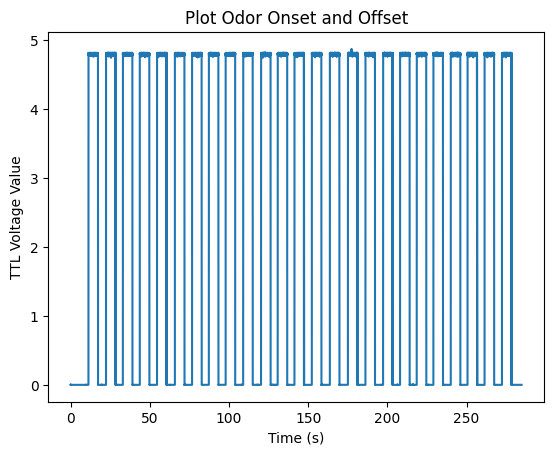

In [5]:
import matplotlib as mpl
# This line increases the limit of how many points can be plotted on matplotlib
mpl.rcParams['agg.path.chunksize'] = 100000

%matplotlib inline
# Converting the time into seconds, by deafult it is nano, since sampling rate is 10kHz
x_values = np.arange(1, olfac_sync.shape[0] + 1) / 10000

# Plot, remembering olfac_sync[1] is the onset of smell. 
plt.plot(x_values, olfac_sync[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('TTL Voltage Value')
plt.title('Plot Odor Onset and Offset')
plt.show()


In [6]:
# blue_ftimes[0]
# plt.plot(x_values,olfac_sync[:,0])
olfac_experiment_start_timestamp

1722286342.6731482

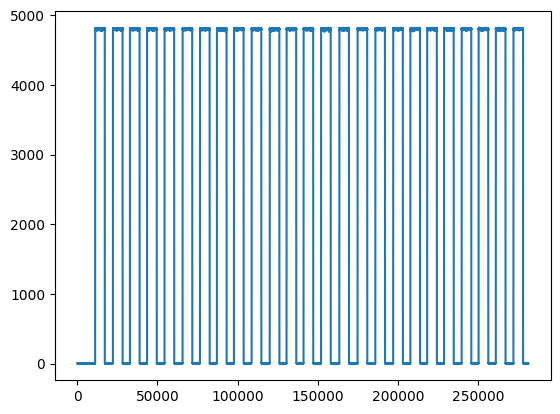

In [7]:
wf_olfac_signal = np.array(analog_data[0])
plt.plot(wf_olfac_signal[4])

In [19]:
normalised_olfac_signal = (olfac_sync[:,1]-np.min(olfac_sync[:,1]))/(np.max(olfac_sync[:,1])-np.min(olfac_sync[:,1]))    
normalised_wf_signal = (wf_olfac_signal[4]-np.min(wf_olfac_signal[4]))/(np.max(wf_olfac_signal[4])-np.min(wf_olfac_signal[4])) 

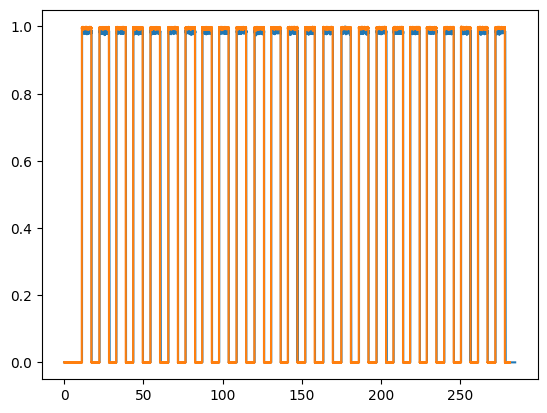

In [45]:
plt.figure
plt.plot(x_values,normalised_olfac_signal)
x_values_two = np.arange(1, wf_olfac_signal.shape[1] + 1) / 1000
plt.plot(x_values_two,normalised_wf_signal)
plt.show()

In [34]:
normalised_wf_signal == normalised_olfac_signal

C:\Users\evilm\AppData\Local\Temp\ipykernel_106908\3881798777.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  normalised_wf_signal == normalised_olfac_signal


False

In [22]:
# Testing motion correction
#print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
#_, _, motion_corrected_frames_all = motion_correct(dat=recordings['recording_1'].all_frames, out=None, mode='ecc', apply_shifts=True)
#print(f'{datetime.datetime.now().time()}: Done Motion Correction')
#np.save(params['path_to_session_data']+"\motion_corrected_data",motion_corrected_frames_all)

In [23]:
# motion_corrected_frames_all = np.load(r"C:\Users\evilm\Downloads\07-18-2024\motion_corrected_data.npy")

In [24]:
# blue_frames = motion_corrected_frames_all[0:2000,0,...]
# violet_frames = motion_corrected_frames_all[0:2000,1,...]
# motion_corrected_frames_all = []

# # Testing Normalising 
# blue_normalised_frames = [(frame-np.min(frame))/(np.max(frame)-np.min(frame)) for frame in tqdm(blue_frames[:])]
# viol_normalised_frames = [(frame-np.min(frame))/(np.max(frame)-np.min(frame)) for frame in tqdm(violet_frames[:])]

# hemo_corrected_frames = [(blue_normalised_frames[i] - viol_normalised_frames[i]) for i in tqdm(range(len(blue_normalised_frames)))]

In [25]:
# # %matplotlib inline
# # import matplotlib.animation as animation
# # plt.figure
# # plt.imshow(blue_normalised_frames[0],cmap='gray')
# # plt.show()

# # plt.figure
# # plt.imshow(viol_normalised_frames[0],cmap='gray')
# # plt.show()

# # hemo_corr = blue_normalised_frames[0]-viol_normalised_frames[0]
# # plt.figure
# # plt.imshow(hemo_corr,cmap='gray')
# # plt.show()

# # print(np.max(hemo_corr))
# # print(np.min(hemo_corr))
# # hemo_corr = (hemo_corr - np.min(hemo_corr))/(np.max(hemo_corr)-np.min(hemo_corr))

# # plt.figure
# # plt.imshow(hemo_corr,cmap='gray')
# # plt.show()
# # print(np.max(hemo_corr))
# # print(np.min(hemo_corr))

# frames = []
# fig = plt.figure()
# for i in tqdm(range(len(hemo_corrected_frames))):
#     frames.append([plt.imshow(hemo_corrected_frames[i],
#                              cmap=plt.cm.Greys_r, animated = True)])
# ani = animation.ArtistAnimation(fig,frames,interval=40, blit = True, repeat_delay=1000)
# #ni.save('movie.mp4')
# plt.show()


In [26]:
# # Testing Denoising and Compression
# motion_corrected_frames_all = np.load(r"C:\Users\evilm\Downloads\07-18-2024\motion_corrected_data.npy")
# # 2. Denoising and Compression
# print(f'{datetime.datetime.now().time()}: Starting  Blue Frames')
# denoised_blue_frames, blueU, blueS, blueVT = denoise_svd(motion_corrected_frames_all[:,0,...],rank=200) # only denoise blue channel for now
# print(f'{datetime.datetime.now().time()}: Done Denoising Blue Frames')

# print(f'{datetime.datetime.now().time()}: Starting  Violet Frames')
# denoised_violet_frames, violetU, violetS, violetVT = denoise_svd(motion_corrected_frames_all[:,1,...],rank=200) # only denoise blue channel for now
# print(f'{datetime.datetime.now().time()}: Done Denoising Violet Frames')

# np.save(params['path_to_session_data']+"\denoised_blue_frames",denoised_blue_frames)
# np.save(params['path_to_session_data']+"\denoised_violet_frames",denoised_violet_frames)
# np.save(params['path_to_session_data']+"\blueU",blueU)
# np.save(params['path_to_session_data']+"\blueS",blueS)
# np.save(params['path_to_session_data']+"\blueVT",blueVT)
# np.save(params['path_to_session_data']+"\violetU",violetU)
# np.save(params['path_to_session_data']+"\violetS",violetS)
# np.save(params['path_to_session_data']+"\violetVT",violetVT)

In [27]:
#get_recording_paths(params['path_to_session_data'])
'''
data = recordings['recording_1'].demo_pipeline()
data = np.array(data)
np.save(params['path_to_session_data']+"\blue_frame_data",data)
'''

'\ndata = recordings[\'recording_1\'].demo_pipeline()\ndata = np.array(data)\nnp.save(params[\'path_to_session_data\']+"\x08lue_frame_data",data)\n'

In [28]:
#data = np.load(r"C:\Users\evilm\Downloads\07-18-2024\blue_frame_data.npy")

In [29]:
#%matplotlib inline
#plt.imshow(np.mean(data,axis=0),cmap="gray")
#plt.show()